In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import random

import plotly.plotly as py
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import scipy.stats
import thinkstats2

import plotly.graph_objs as go

pd.set_option("display.max_columns",None)

In [2]:
salaries = pd.read_csv('Salaries.csv')
app_train = pd.read_csv('application_train.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (3,4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
salaries.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [4]:
salaries_2011 = salaries[salaries['Year'] == 2011]
salaries_2012 = salaries[salaries['Year'] == 2012]
salaries_2013 = salaries[salaries['Year'] == 2013]
salaries_2014 = salaries[salaries['Year'] == 2014]

In [5]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

In [6]:
class MeanPermutation(HypothesisTest):
    
    def TestStatistic(self, data):
        group1, group2 = data
        stat = np.mean(group1)-np.mean(group2)
        return stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [7]:
class MeanResample(HypothesisTest):
    
    def TestStatistic(self, data):
        group1, group2 = data
        stat = np.mean(group1)-np.mean(group2)
        return stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
        
    def RunModel(self):
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2

In [8]:
totalpay_2011 = salaries_2011['TotalPay'].sample(n=100)#, random_state=47)
totalpay_2012 = salaries_2012['TotalPay'].sample(n=100)#, random_state=47)

print(np.mean(totalpay_2012)-np.mean(totalpay_2011))

14.021299999963958


In [9]:
data = totalpay_2012, totalpay_2011
h = MeanPermutation(data)
perm_pval = h.PValue()

h = MeanResample(data)
samp_pval = h.PValue()

print('Permutation = %.4f' %perm_pval)
print('Resampling = %.4f' %samp_pval)

Permutation = 0.4980
Resampling = 0.4820


In [10]:
print(np.mean(salaries_2012['TotalPay'])-np.mean(salaries_2011['TotalPay']))

2369.158393900725


In [11]:
class DiceTest(HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

In [12]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

In [13]:
class MyDiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = scipy.stats.chisquare(observed, expected, ddof=5)[0]
        return test_stat

In [14]:
class CoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [np.random.choice(['H','T']) for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

In [15]:
class ChiCoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        expected = (heads+tails)/2, (heads+tails)/2
        test_stat = scipy.stats.chisquare(data, expected, ddof=1)[0]
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice(['H','T']) for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

In [16]:
ct = CoinTest((130, 120))
pvalue = ct.PValue()
pvalue

0.552

In [17]:
ct = ChiCoinTest((130, 120))
pvalue = ct.PValue()
pvalue

0.574

In [18]:
observed = [9,7,1,22,11,10]
h1 = DiceChiTest(observed)
print(h1.PValue())

0.0


In [19]:
h2 = MyDiceChiTest(observed)
print(h2.PValue())

0.0


In [20]:
salaries_2011.dropna(subset=['TotalPay', 'BasePay'], inplace=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [21]:
totalpay_2011 = salaries_2011['TotalPay'].sample(n=10000, random_state=47, replace=True)
basepay_2011 = salaries_2012['BasePay'].sample(n=10000, random_state=47, replace=True)

data = totalpay_2011, basepay_2011

In [22]:
def Cov(xs,ys):
    meanx = np.mean(xs)
    meany = np.mean(ys)
    
    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [23]:
def PearsonCorr(xs, ys):
    xstd = np.std(xs)
    ystd = np.std(ys)
    
    return Cov(xs, ys)/(xstd*ystd)

In [24]:
PearsonCorr(salaries_2011['TotalPay'], salaries_2011['BasePay'])

0.9531353297911876

In [25]:
class TestCorr(HypothesisTest):
    
    def RunModel(self):
        xs, ps = self.data
        xs = np.random.permutation(xs)
        return xs, ps
    
    def TestStatistic(self, data):
        xs, ps = data
        corr = PearsonCorr(xs, ps)
        return corr

In [26]:
h = TestCorr(data)
pval = h.PValue()
pval

0.075

In [27]:
np.corrcoef(x=list(salaries_2011['TotalPay']), y=list(salaries_2011['BasePay']))

array([[1.        , 0.95313533],
       [0.95313533, 1.        ]])

In [28]:
scipy.stats.pearsonr(x=list(salaries_2011['TotalPay']), y=list(salaries_2011['BasePay']))

(0.953135329791181, 0.0)

In [29]:
def CohensD(xs, ys):
    meanx = np.mean(xs)
    meany = np.mean(ys)
    
    sdpooled = np.sqrt((np.var(xs) + np.var(ys))/2)
    
    cohens = (meanx-meany)/sdpooled
    return cohens

In [30]:
totalpay_2011_2 = salaries_2011['TotalPay'].sample(n=10000, random_state=47)
basepay_2011_2 = salaries_2012['BasePay'].sample(n=10000, random_state=47)

In [31]:
CohensD(totalpay_2011, totalpay_2012)

0.13643026946928555

In [32]:
CohensD(totalpay_2011_2, basepay_2011_2)

0.15371351347445275

In [33]:
print(np.mean(totalpay_2011), np.mean(totalpay_2012))

70788.37007399982 64442.64559999996


In [34]:
print(np.std(totalpay_2011), np.std(totalpay_2012))

46983.36506660205 46036.990465810704


In [35]:
sdpooled = np.sqrt((np.var(totalpay_2011) + np.var(totalpay_2012))/2)
sdpooled

46512.58477084857

In [36]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [37]:
male_popul = app_train.loc[app_train['CODE_GENDER'] == 'M', 'AMT_CREDIT']
female_popul = app_train.loc[app_train['CODE_GENDER'] == 'F', 'AMT_CREDIT']

In [38]:
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

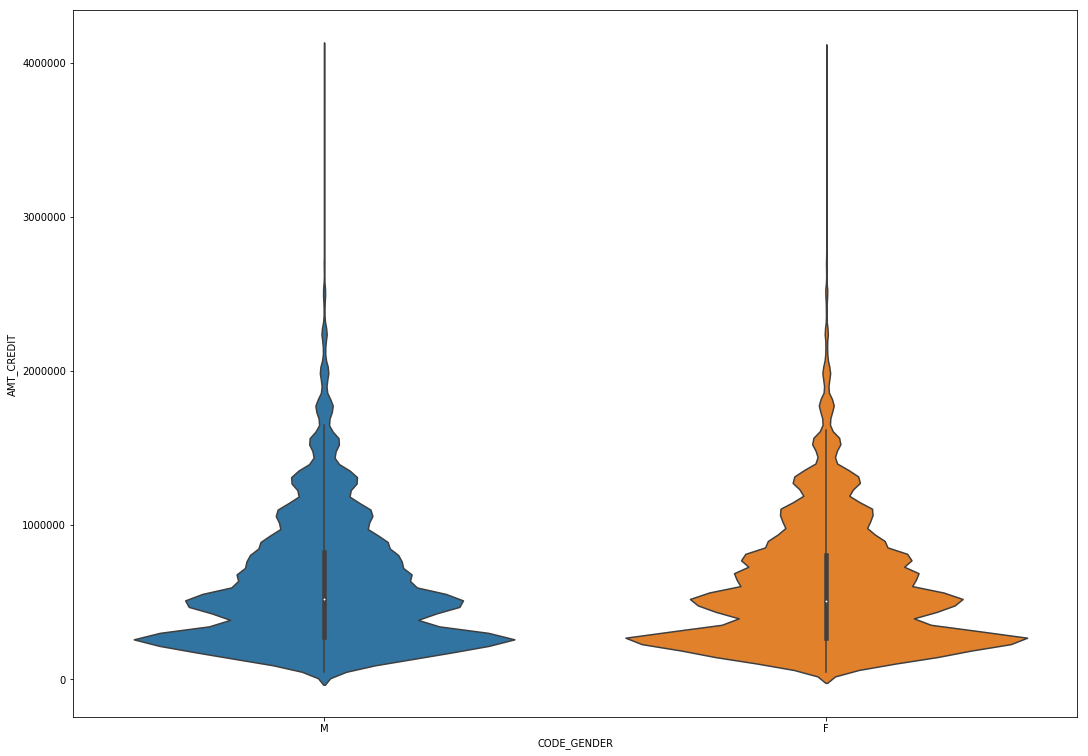

In [39]:
plt.figure(figsize=(18,13))
sns.violinplot(x='CODE_GENDER', y='AMT_CREDIT', data=app_train)

In [40]:
male_sample = male_popul.sample(n=4000, random_state=47)
female_sample = female_popul.sample(n=4000, random_state=47)

In [41]:
print(np.mean(male_popul) - np.mean(female_popul))
print(np.mean(male_sample) - np.mean(female_sample))

18328.479779310757
24188.136750000063


In [42]:
CohensD(male_popul, female_popul)

0.04529896087641285

In [43]:
CohensD(male_sample, female_sample)

0.059416300174105714

In [44]:
data = male_sample, female_sample
h = MeanPermutation(data)
h.PValue()

0.008